<a href="https://colab.research.google.com/github/sournara/Computer_Vision_Study/blob/main/PyTorch/PyTorch_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 학습 코드를 실행하기 전에 [런타임]-[런타임 유형 변경]에서 하드웨어 가속기를 [GPU]로 설정한다.
### **데이터 세트 다운로드**
- 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [1]:
!git clone https://github.com/ndb796/weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 14.71 MiB/s, done.


In [2]:
%cd weather_dataset

/content/weather_dataset


### **라이브러리 불러오기(Load Libraries)**
- 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### **데이터 세트 불러오기(Load Dataset)**
1. 데이터 증진(data augmentation)을 명시하여 초기화할 수 있다.
  - 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 DataLoader()을 이용하여 실질적으로 데이터를 불러올 수 있다.
  - 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
  - next() 함수를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.

- Reference : https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

In [5]:
train_dataset = datasets.ImageFolder(
    root = 'train/',
    transform = transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root = 'test/',
    transform = transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

### **데이터 시각화(Data Visualization)**

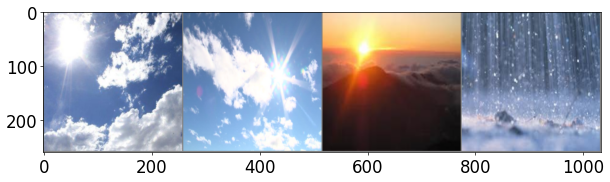

['Shine', 'Shine', 'Sunrise', 'Rain']


In [6]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size' : 20})

def imshow(input) :
  # torch.Tensor => numpy
  input = input.numpy().transpose((1, 2, 0))
  # undo image normalization
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  input = std * input + mean
  input = np.clip(input, 0, 1)
  # display images
  plt.imshow(input)
  plt.show()

class_names = {
    0 : "Cloudy",
    1 : "Rain",
    2 : "Shine",
    3 : "Sunrise"
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

### **딥러닝 모델 학습(Training)**
- 사전 학습된(pre-trained) 모델을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능하다.
  - 네트워크의 마지막 FC 레이어를 적용하여 클래스 개수를 일치시킨다.

In [7]:
learning_rate = 0.01
log_step = 20

model = models.resnet50(pretrained = True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [8]:
import time

def train() :
  start_time = time.time()
  print(f"[Epoch : {epoch + 1} - Training]")
  model.train()
  total = 0
  running_loss = 0.0
  running_corrects = 0

  for i, batch in enumerate(train_dataloader) :
    imgs, labels = batch
    imgs, labels = imgs.cuda(), labels.cuda()

    outputs = model(imgs)
    optimizer.zero_grad()
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    total += labels.shape[0]
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    if i % log_step == log_step - 1 :
      print(f"[Batch : {i + 1}] running train loss : {running_loss / total}, running train accuracy : {running_corrects / total}")

  print(f'train loss : {running_loss / total}, accuracy : {running_corrects / total}')
  print("elpased time : ", time.time() - start_time)
  return running_loss / total, (running_corrects / total).item()

def validate() :
  start_time = time.time()
  print(f'[Epoch : {epoch + 1} - Validation]')
  model.eval()
  total = 0
  running_loss = 0.0
  running_corrects = 0

  for i, batch in enumerate(val_dataloader) :
    imgs, labels = batch
    imgs, labels = imgs.cuda(), labels.cuda()

    with torch.no_grad() :
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    total += labels.shape[0]
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    if (i == 0) or (i % log_step == log_step - 1) :
      print(f'[Batch : {i + 1}] running val loss : {running_loss / total}, running val accuracy : {running_corrects / total}')

  print(f'val loss : {running_loss / total}, accuracy : {running_corrects / total}')
  print('elapsed time :', time.time() - start_time)
  return running_loss / total, (running_corrects / total).item()

def test() :
  start_time = time.time()
  print(f'[Test]')
  model.eval()
  total = 0
  running_loss = 0.0
  running_corrects = 0

  for i, batch in enumerate(test_dataloader) :
    imgs, labels = batch
    imgs, labels = imgs.cuda(), labels.cuda()

    with torch.no_grad() :
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    total += labels.shape[0]
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    if (i == 0) or (i % log_step == log_step - 1) :
      print(f'[Batch : {i + 1}] running test loss : {running_loss / total}, running test accuracy : {running_corrects / total}')

  print(f'test loss : {running_loss / total}, accuracy : {running_corrects / total}')
  print('elapsed time :', time.time() - start_time)
  return running_loss / total, (running_corrects / total).item()

In [9]:
import time

def adjust_learning_rate(optimizer, epoch) :
  lr = learning_rate
  if epoch >= 3 :
    lr /= 10
  if epoch >= 7 :
    lr /= 10
  for param_group in optimizer.param_groups :
    param_group['lr'] = lr

num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs) :
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train()
  val_loss, val_acc = validate()
  history.append((train_loss, val_loss))
  accuracy.append((train_acc, val_acc))

  if val_acc > best_val_acc :
    print("[Info] best validation accuracy!")
    best_val_acc = val_acc
    best_epoch = epoch
    torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

[Epoch : 1 - Training]
train loss : 0.01167877698386157, accuracy : 0.7111111283302307
elpased time :  14.341906547546387
[Epoch : 1 - Validation]
[Batch : 1] running val loss : 0.00544244097545743, running val accuracy : 0.875
val loss : 0.005910150133646452, accuracy : 0.8698225021362305
elapsed time : 2.103245735168457
[Info] best validation accuracy!
[Epoch : 2 - Training]
train loss : 0.0012752988010093019, accuracy : 0.9792592525482178
elpased time :  13.373781681060791
[Epoch : 2 - Validation]
[Batch : 1] running val loss : 0.003758467035368085, running val accuracy : 0.921875
val loss : 0.0037880494044377254, accuracy : 0.9289941191673279
elapsed time : 1.8355355262756348
[Info] best validation accuracy!
[Epoch : 3 - Training]
train loss : 0.00036190850970645747, accuracy : 0.9925925731658936
elpased time :  13.437509298324585
[Epoch : 3 - Validation]
[Batch : 1] running val loss : 0.0032448014244437218, running val accuracy : 0.9375
val loss : 0.0029697786774155657, accuracy :

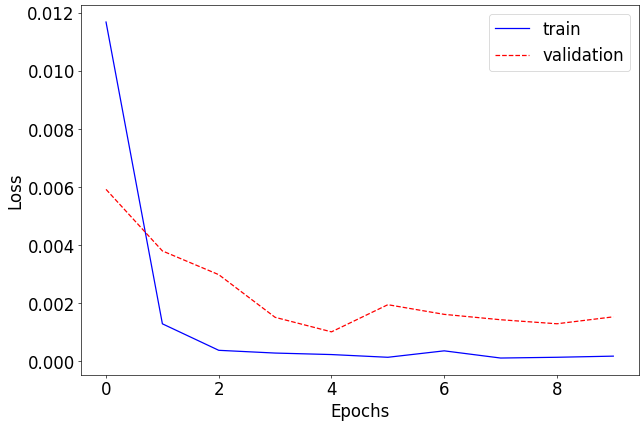

In [10]:
plt.plot([x[0] for x in history], 'b', label = 'train')
plt.plot([x[1] for x in history], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [11]:
model = models.resnet50(pretrained = True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()
model_path = 'best_checkpoint_epoch_5.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss :.8f}")
print(f"Test accuracy : {test_accuracy * 100.:.2f}%")

[Test]
[Batch : 1] running test loss : 0.0005250637768767774, running test accuracy : 0.96875
test loss : 0.0012006446546410936, accuracy : 0.9786476492881775
elapsed time : 1.8894846439361572
Test loss : 0.00120064
Test accuracy : 97.86%
